# GeoJSON to Shapefile

Creating a Shapefile from two GeoJSON files:

In [26]:
import geopandas as gpd
import pandas as pd

files = [
    '51afd3da5d5a783b576af4cce9b93e8d.json',
    'f7bf04d6f83e4e7e347742c609fc7059.json'
]

gdf = gpd.read_file('51afd3da5d5a783b576af4cce9b93e8d.json')
gdf = gdf.append(gpd.read_file('f7bf04d6f83e4e7e347742c609fc7059.json'))
gdf.to_file('points.shp')

Checking this was saved correctly:

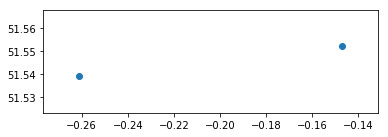

In [32]:
import plotly.express as px

%matplotlib inline

gdf = gpd.read_file('points.shp')
gdf.plot()

# GeoJSON to GeoTIFF

Creating a GeoTIFF file using a GeoJSON shape, by using the shape to clip a larger raster.

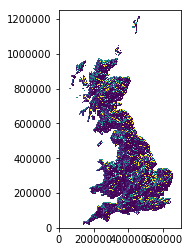

In [2]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

%matplotlib inline

# Open the large raster to clip down
rs = rio.open('example_raster.tif')
show(rs)

Loading the JSON and creating a Shapely Polygon from it:

Bounds (original CRS): (-0.2273235804894398, 51.558797354342516, -0.16147891874280162, 51.60364433752355)


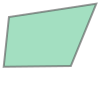

In [4]:
import json
from shapely.geometry import shape

with open('00bbda8b068d775fe1f835c32d52a15c.json') as file:
    area = json.load(file)
    
geom = shape(area['geometry'])
print(f"Bounds (original CRS): {geom.bounds}")
geom

We need to convert the geometry to same CRS as the raster to clip, especially seeing as the GeoJSON is lat/lon and the raster is projected. For the NanoFASE model, the desired CRS is EPSG:27700. Here, I assume the GeoJSON file was EPSG:4326:

Bounds (EPSG:27700): (522983.7623877871, 185923.77746658964, 527422.5520781561, 191023.67125141388)


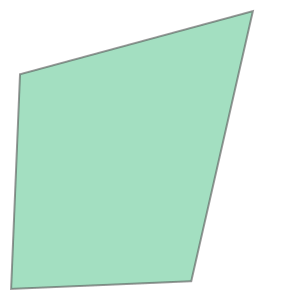

In [5]:
from functools import partial
import pyproj
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),  # Source coordinate system (WGS84)
    pyproj.Proj(init='epsg:27700')) # Destination coordinate system (British National Grid)
# Do the transformation
geom_transformed = transform(project, geom)
print(f"Bounds (EPSG:27700): {geom_transformed.bounds}")
geom_transformed

Using Rasterio's mask method to clip using this polygon and save to new file:

In [6]:
# Do the clipping
out_ma, out_transform = mask(rs, [geom_transformed], crop=True, filled=False)
# Copy over the metadata
out_meta = rs.meta
# Update the height, width and transform for the new raster
out_meta.update({"driver": "GTiff",
                 "height": out_ma.shape[1],
                 "width": out_ma.shape[2],
                 "transform": out_transform})
# Write the new raster to file
with rio.open("clipped.tif", "w", **out_meta) as dest:
    dest.write(out_ma)

Checking this saved okay:

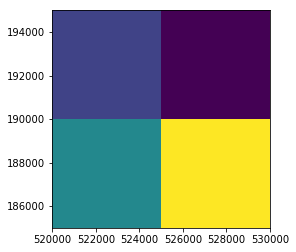

In [7]:
with rio.open("clipped.tif") as rs:
    rio.plot.show(rs)

# GeoJSON to GeoTIFF without a raster to clip

Creating a GeoTIFF with a constant value, with the same extent as a GeoJSON file. Assuming we've already created a Shapely polygon from the GeoJSON and transformed it (as per above).

In [53]:
import numpy as np
from rasterio.transform import from_bounds

# Grid cell resolution
res = 5000

# Get the bounds of the Shapely polygon, used to set the height/width of raster
minx, miny, maxx, maxy = geom_transformed.bounds
# Assume we want all pixels (cells) touched by the polygon, so round the min and max coords to encompass these
minx_rounded = minx - minx % res
maxx_rounded = maxx + (res - maxx) % res
miny_rounded = miny - miny % res
maxy_rounded = maxy + (res - maxy) % res
shape = (1,
         int((maxx_rounded - minx_rounded) / res),
         int((maxy_rounded - miny_rounded) / res))

# Create an array with these dimensions and fill with a constant value
arr = np.full(shape, fill_value=42.0)

# Create an affine transformation to use to create raster
transform = from_bounds(minx_rounded, miny_rounded, maxx_rounded, maxy_rounded, shape[1], shape[2])

# Create out_meta to pass to rasterio when creating the raster
out_meta = {
    "driver": "GTiff",
    "height": shape[1],
    "width": shape[2],
    "transform": transform,
    "count": 1,
    "dtype": arr.dtype,
    "crs": 'EPSG:27700'
}

with rio.open('constant_rs.tif', 'w', **out_meta) as dest:
    dest.write(arr)

Checking the raster was saved correctly:

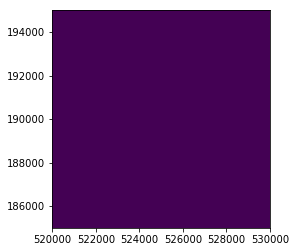

In [54]:
with rio.open('constant_rs.tif') as src:
    show(src)

The above will create a raster with the bounding box being the bounding box of the polygon. However, it won't be clipped to the polygon itself (e.g. if the polygon is a shape such that there are cells within the bounding box that aren't in the polygon). To do that, it's easiest to mask this raster as we did before:

In [ ]:
# Do the clipping
with open('constant_rs.tif') as src:
    out_ma, out_transform = mask(src, [geom_transformed], crop=True, filled=False)
    out_meta = src.meta

## We shouldn't have to update the metadata for the raster - it should be the same

# Write the clipped raster
with rio.open("clipped.tif", "w", **out_meta) as dest:
    dest.write(out_ma)